In [30]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras
import time

from datetime import date
from matplotlib import pyplot as plt
from numpy.random import seed
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.utils import plot_model

#### Input params ##################
stk_path = "./csv/TLRY.timeseries.csv"
test_size = 0.2                # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set

N = 9                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features. 
                               # initial value before tuning
lstm_units=50                  # lstm param. initial value before tuning.
dropout_prob=1                 # lstm param. initial value before tuning.
optimizer='adam'               # lstm param. initial value before tuning.
epochs=1                       # lstm param. initial value before tuning.
batch_size=1                   # lstm param. initial value before tuning.

model_seed = 100

fontsize = 14
ticklabelsize = 14
####################################

# Set seeds to ensure same output results
seed(101)
tf.random.set_seed(model_seed)

In [16]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_x_y(data, N, offset):
    """
    Split data into x (features) and y (target)
    """
    x, y = [], []
    for i in range(offset, len(data)):
        x.append(data[i-N:i])
        y.append(data[i])
    x = np.array(x)
    y = np.array(y)
    
    return x, y

def get_x_scaled_y(data, N, offset):
    """
    Split data into x (features) and y (target)
    We scale x to have mean 0 and std dev 1, and return this.
    We do not scale y here.
    Inputs
        data     : pandas series to extract x and y
        N
        offset
    Outputs
        x_scaled : features used to predict y. Scaled such that each element has mean 0 and std dev 1
        y        : target values. Not scaled
        mu_list  : list of the means. Same length as x_scaled and y
        std_list : list of the std devs. Same length as x_scaled and y
    """
    x_scaled, y, mu_list, std_list = [], [], [], []
    for i in range(offset, len(data)):
        mu_list.append(np.mean(data[i-N:i]))
        std_list.append(np.std(data[i-N:i]))
        x_scaled.append((data[i-N:i]-mu_list[i-offset])/std_list[i-offset])
        y.append(data[i])
    x_scaled = np.array(x_scaled)
    y = np.array(y)
    
    return x_scaled, y, mu_list, std_list

def train_pred_eval_model(x_train_scaled, \
                          y_train_scaled, \
                          x_cv_scaled, \
                          y_cv, \
                          mu_cv_list, \
                          std_cv_list, \
                          lstm_units=50, \
                          dropout_prob=0.5, \
                          optimizer='adam', \
                          epochs=1, \
                          batch_size=1):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use LSTM here.
    Returns rmse, mape and predicted values
    Inputs
        x_train_scaled  : e.g. x_train_scaled.shape=(451, 9, 1). Here we are using the past 9 values to predict the next value
        y_train_scaled  : e.g. y_train_scaled.shape=(451, 1)
        x_cv_scaled     : use this to do predictions 
        y_cv            : actual value of the predictions
        mu_cv_list      : list of the means. Same length as x_scaled and y
        std_cv_list     : list of the std devs. Same length as x_scaled and y 
        lstm_units      : lstm param
        dropout_prob    : lstm param
        optimizer       : lstm param
        epochs          : lstm param
        batch_size      : lstm param
    Outputs
        rmse            : root mean square error
        mape            : mean absolute percentage error
        est             : predictions
    '''
    # Create the LSTM network
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1],1)))
    model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
    model.add(Dense(1))

    # Compile and fit the LSTM network
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0)
    
    # Do prediction
    est_scaled = model.predict(x_cv_scaled)
    est = (est_scaled * np.array(std_cv_list).reshape(-1,1)) + np.array(mu_cv_list).reshape(-1,1)
    
    # Calculate RMSE and MAPE
#     print("x_cv_scaled = " + str(x_cv_scaled))
#     print("est_scaled = " + str(est_scaled))
#     print("est = " + str(est))
    rmse = math.sqrt(mean_squared_error(y_cv, est))
    mape = get_mape(y_cv, est)
        
    return rmse, mape, est

In [17]:
df = pd.read_csv(stk_path, sep = ",")

# Convert Date column to datetime
df.loc[:, 'date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head()

,date,open,high,low,close,volume,adjclose,month
363,2018-07-19,23.049999,24.000000,20.100000,22.389999,11934500,22.389999,7
362,2018-07-20,24.250000,31.799999,23.500000,29.770000,13938200,29.770000,7
361,2018-07-23,33.480000,34.099998,29.309999,29.450001,10042900,29.450001,7
360,2018-07-24,28.799999,29.430000,25.250000,25.360001,5524200,25.360001,7
359,2018-07-25,25.309999,27.150000,24.200001,26.490000,3844100,26.490000,7


Text(0, 0.5, 'USD')

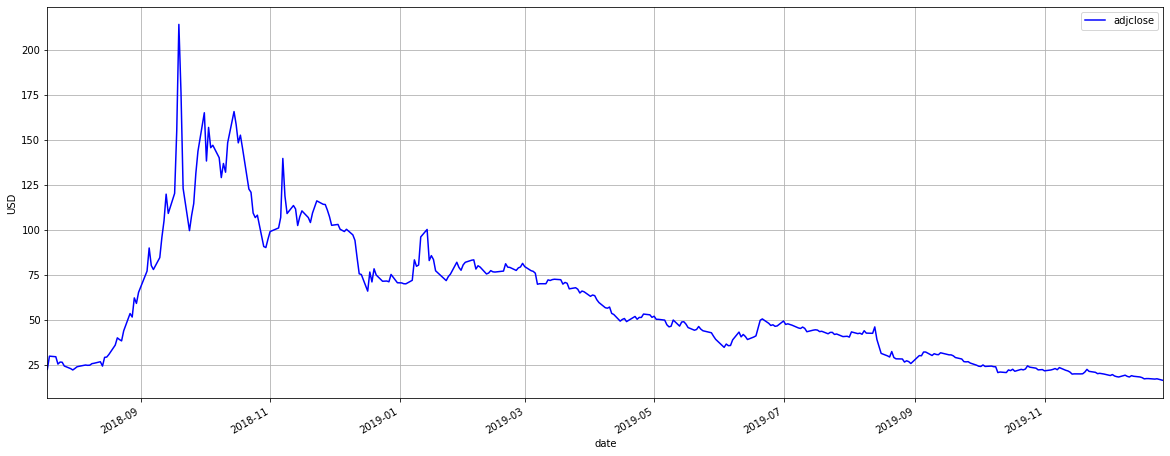

In [18]:

# Plot adjusted close over time
rcParams['figure.figsize'] = 20, 8 # width 10, height 8

ax = df.plot(x='date', y='adjclose', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [19]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train][['date', 'adjclose']]
cv = df[num_train:num_train+num_cv][['date', 'adjclose']]
train_cv = df[:num_train+num_cv][['date', 'adjclose']]
test = df[num_train+num_cv:][['date', 'adjclose']]

print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 220
num_cv = 72
num_test = 72
train.shape = (220, 2)
cv.shape = (72, 2)
train_cv.shape = (292, 2)
test.shape = (72, 2)


In [20]:
# Converting dataset into x_train and y_train
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(np.array(train['adjclose']).reshape(-1,1))
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))

# Split into x and y
x_train_scaled, y_train_scaled = get_x_y(train_scaled, N, N)
print("x_train_scaled.shape = " + str(x_train_scaled.shape)) # (446, 7, 1)
print("y_train_scaled.shape = " + str(y_train_scaled.shape)) # (446, 1)

scaler.mean_ = [77.61277285]
scaler.var_ = [1222.78083229]
x_train_scaled.shape = (211, 9, 1)
y_train_scaled.shape = (211, 1)


In [21]:
# Scale the cv dataset
# Split into x and y
x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['adjclose']).reshape(-1,1), N, num_train)
print("x_cv_scaled.shape = " + str(x_cv_scaled.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("len(mu_cv_list) = " + str(len(mu_cv_list)))
print("len(std_cv_list) = " + str(len(std_cv_list)))

x_cv_scaled.shape = (72, 9, 1)
y_cv.shape = (72, 1)
len(mu_cv_list) = 72
len(std_cv_list) = 72


In [22]:

# Here we scale the train_cv set, for the final model
scaler_final = StandardScaler()
train_cv_scaled_final = scaler_final.fit_transform(np.array(train_cv['adjclose']).reshape(-1,1))
print("scaler_final.mean_ = " + str(scaler_final.mean_))
print("scaler_final.var_ = " + str(scaler_final.var_))

# Scale the test dataset
x_test_scaled, y_test, mu_test_list, std_test_list = get_x_scaled_y(np.array(df['adjclose']).reshape(-1,1), N, num_train+num_cv)
print("x_test_scaled.shape = " + str(x_test_scaled.shape))
print("y_test.shape = " + str(y_test.shape))
print("len(mu_test_list) = " + str(len(mu_test_list)))
print("len(std_test_list) = " + str(len(std_test_list)))

scaler_final.mean_ = [68.17089053]
scaler_final.var_ = [1205.35663514]
x_test_scaled.shape = (72, 9, 1)
y_test.shape = (72, 1)
len(mu_test_list) = 72
len(std_test_list) = 72


In [23]:
# Create the LSTM network
model = Sequential()
model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1],1)))
model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
model.add(LSTM(units=lstm_units))
model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=optimizer)
model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=2)

ValueError: rate must be a scalar tensor or a float in the range [0, 1), got 1

In [10]:
# Print model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 9, 50)             10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Plot model and save to file
from IPython.display import SVG
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils.vis_utils import model_to_dot

ModuleNotFoundError: No module named 'tensorflow.keras.utils.vis_utils'

In [12]:

# Do prediction
est_scaled = model.predict(x_cv_scaled)
est = (est_scaled * np.array(std_cv_list).reshape(-1,1)) + np.array(mu_cv_list).reshape(-1,1)
print("est.shape = " + str(est.shape))

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, est))
print("RMSE = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_pct_bef_tuning = get_mape(y_cv, est)
print("MAPE = %0.3f%%" % mape_pct_bef_tuning)

C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"


est.shape = (2006, 1)
RMSE = 0.540
MAPE = 3.081%


Text(0, 0.5, 'USD')

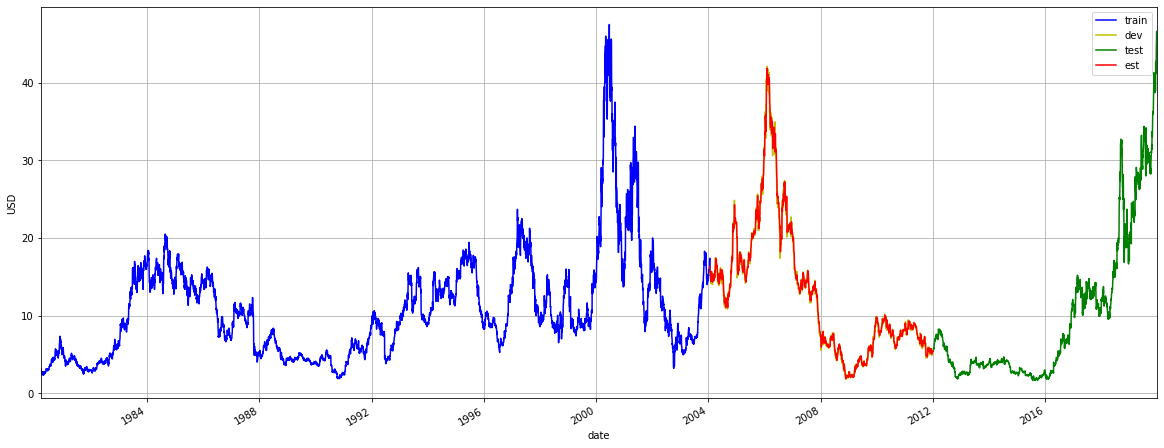

In [13]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 20, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est.reshape(-1), 
                       'y_cv': y_cv.reshape(-1),
                       'date': cv['date']})

ax = train.plot(x='date', y='adjclose', style='b-', grid=True)
ax = cv.plot(x='date', y='adjclose', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adjclose', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'est'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [14]:
param_label = 'N'
param_list = range(3, 60)

error_rate = {param_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    
    # Split train into x and y
    x_train_scaled, y_train_scaled = get_x_y(train_scaled, param, param)

    # Split cv into x and y
    x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['adjclose']).reshape(-1,1), param, num_train)
    
    # Train, predict and eval model
    rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                          y_train_scaled, \
                                          x_cv_scaled, \
                                          y_cv, \
                                          mu_cv_list, \
                                          std_cv_list, \
                                          lstm_units=lstm_units, \
                                          dropout_prob=dropout_prob, \
                                          optimizer=optimizer, \
                                          epochs=epochs, \
                                          batch_size=batch_size)
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate

C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not avai

C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not avai

C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not avai

C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not avai

C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not avai

C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not avai

C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not avai

C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not avai

C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not avai

C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not avai

C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not avai

C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not avai

C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not avai

C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not avai

C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not avai

C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not avai

C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not avai

C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not avai


Minutes taken = 76.7358351667722


,N,rmse,mape_pct
0,3,0.571386,3.273865
1,4,0.580041,3.330152
2,5,0.566792,3.247809
3,6,0.535802,3.048874
4,7,0.544065,3.100469
5,8,0.543179,3.101105
6,9,0.535496,3.047555
7,10,0.536473,3.055021
8,11,0.539564,3.076164
9,12,0.524471,2.967476


Text(0, 0.5, 'RMSE/MAPE(%)')

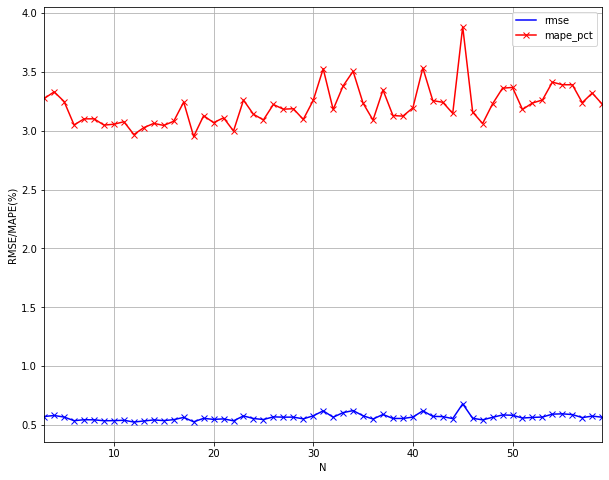

In [15]:
# Plot RMSE 
rcParams['figure.figsize'] = 20, 8 # width 10, height 8

ax = error_rate.plot(x='N', y='rmse', style='bx-', grid=True)
ax = error_rate.plot(x='N', y='mape_pct', style='rx-', grid=True, ax=ax)
ax.set_xlabel("N")
ax.set_ylabel("RMSE/MAPE(%)")

In [16]:
# Get optimum value for param
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
N_opt = temp['N'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(N_opt))

min RMSE = 0.524
min MAPE = 2.951%
optimum N = 12


In [ ]:
param_label = 'epochs'
param_list = [1, 10, 20, 30, 40, 50]

param2_label = 'batch_size'
param2_list = [8, 16, 32, 64, 128]

# Split train into x and y
x_train_scaled, y_train_scaled = get_x_y(train_scaled, N_opt, N_opt)

# Split cv into x and y
x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['adjclose']).reshape(-1,1), N_opt, num_train)

error_rate = {param_label: [], param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    
    for param2 in tqdm_notebook(param2_list):
    
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                              y_train_scaled, \
                                              x_cv_scaled, \
                                              y_cv, \
                                              mu_cv_list, \
                                              std_cv_list, \
                                              lstm_units=lstm_units, \
                                              dropout_prob=dropout_prob, \
                                              optimizer=optimizer, \
                                              epochs=param, \
                                              batch_size=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate

C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not avai

C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not avai

C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not avai

C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not avai

C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not avai

C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not avai

C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not avai

C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not avai

C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\reggl\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not avai

In [ ]:

# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure
# ax.set_xlim([10, 50])
# ax.set_ylim([0, 5])

In [ ]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
epochs_opt = temp[param_label].values[0]
batch_size_opt = temp[param2_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(epochs_opt))
print("optimum " + param2_label + " = " + str(batch_size_opt))

In [ ]:
param_label = 'lstm_units'
param_list = [10, 50, 64, 128]

param2_label = 'dropout_prob'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [], param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    
    for param2 in tqdm_notebook(param2_list):
    
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                              y_train_scaled, \
                                              x_cv_scaled, \
                                              y_cv, \
                                              mu_cv_list, \
                                              std_cv_list, \
                                              lstm_units=param, \
                                              dropout_prob=param2, \
                                              optimizer=optimizer, \
                                              epochs=epochs_opt, \
                                              batch_size=batch_size_opt)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate

In [ ]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [ ]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
lstm_units_opt = temp[param_label].values[0]
dropout_prob_opt = temp[param2_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(lstm_units_opt))
print("optimum " + param2_label + " = " + str(dropout_prob_opt))

In [ ]:

param_label = 'optimizer'
param_list = ['adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', 'nadam']

error_rate = {param_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
   
    # Train, predict and eval model
    rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                          y_train_scaled, \
                                          x_cv_scaled, \
                                          y_cv, \
                                          mu_cv_list, \
                                          std_cv_list, \
                                          lstm_units=lstm_units_opt, \
                                          dropout_prob=dropout_prob_opt, \
                                          optimizer=param, \
                                          epochs=epochs_opt, \
                                          batch_size=batch_size_opt)
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate